# Skipgram

## 1.Load data

In [1]:
import numpy as np 
import torch 
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt 
import spacy
import pandas as pd 
import time 
import itertools
from numpy import dot
from numpy.linalg import norm
nlp = spacy.load("en_core_web_sm")

### Load corpus data from txt file, which referenced from our classmates

In [3]:
f = ((open("questions-words.txt", "r")).read()).split(":")
corpus_syntactic = (f[14]).split("\n")[1:-1] # Singular and Plural Verbs
corpus_semantic = (f[3]).split("\n")[1:-1] + (f[5]).split("\n")[1:-1] # Family [boy, girl, brother, sister]

corpus = corpus_semantic + corpus_syntactic

word = [[corpus[i]] for i in range(len(corpus))] #extract the data

corpus_syntactic = [[corpus_syntactic[i]] for i in range(len(corpus_syntactic))] #contain the corpus in list
corpus_semantic = [[corpus_semantic[i]] for i in range(len(corpus_semantic))]

In [4]:
len(word) # take a quick look

2241

## 2.Tokenization

In [5]:
def tokenize(corpus_input) : #Tokenize function
    corpus_tokenizedd = []
    for token in corpus_input : 
        spare = []
        for ss in nlp(str(token[0])) :
            spare.append(str(ss))
        corpus_tokenizedd.append(spare)    
    return corpus_tokenizedd  

In [6]:
corpus_tokenized = tokenize(word)

cor_sem_token = tokenize(corpus_semantic) # this data is used to test syntactic and semantic accuracy
cor_syn_token = tokenize(corpus_syntactic)

In [7]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))
vocabs_syn  = list(set(flatten(cor_syn_token)))
vocabs_sem  = list(set(flatten(cor_sem_token)))

In [8]:
vocabs[0:10] # check some examples

['peso',
 'Armenia',
 'man',
 'swim',
 'describes',
 'Angola',
 'India',
 'eats',
 'walks',
 'Bulgaria']

## 3.Numerization

In [9]:
word_2_idx = {v: idx for idx, v in enumerate(vocabs)}
vocabs.append('<UNK>')
word_2_idx['<UNK>'] = len(word_2_idx) 

In [10]:
dict(itertools.islice(word_2_idx.items(), 10)) # quick check

{'peso': 0,
 'Armenia': 1,
 'man': 2,
 'swim': 3,
 'describes': 4,
 'Angola': 5,
 'India': 6,
 'eats': 7,
 'walks': 8,
 'Bulgaria': 9}

## 4.Prepare data

In [11]:
def random_batch_skipgram(batch_size, corpus_tokenized):
    
    Skipgram = []

    #for each corpus
    for sent in corpus_tokenized:
        try :
            for i in range(1, len(sent) - 1): #start from 1 to second last
                center_word = word_2_idx[sent[i]]
                outside_words = [word_2_idx[sent[i-1]], word_2_idx[sent[i+1]]]  #window_size = 1
                for o in outside_words:
                    Skipgram.append([center_word, o]) #use outside word to predict center word
        except :
            pass               
    #only get a batch, not the entire list
    random_inputs, random_labels = [], []   
    random_index = np.random.choice(range(len(Skipgram)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    for index in random_index:
        random_inputs.append([Skipgram[index][0]])  
        random_labels.append([Skipgram[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

## 5.Model

In [12]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size) -> note about the shape
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        top_term_exp = torch.exp(top_term) 
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) 
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))

        
        return loss_fn

## 6. Train

In [13]:
voc_size = len(vocabs)
batch_size = 2 
emb_size   = 3
Skipgram   = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(Skipgram.parameters(), lr=0.001)

num_epochs = 4000

In [14]:
def prepare_sequence(seq, word2index):

    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word_2_idx).expand(batch_size, voc_size)
all_vocabs.shape # quick check

torch.Size([2, 165])

In [15]:
def epoch_time(start_time, end_time):
    elapsed_time = (end_time - start_time)
    return elapsed_time

In [16]:
run_time_normal = 0
sum_time = 0
#for epoch
for epoch in range(num_epochs):
    start_time = time.time()

    #get random batch
    input_batch, label_batch = random_batch_skipgram(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    
    #loss = model
    
    optimizer.zero_grad()
    loss = Skipgram(input_batch, label_batch, all_vocabs)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()
    stop_time = time.time()
    run_time_normal = run_time_normal + epoch_time(start_time, stop_time)
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        sum_time += run_time_normal
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {run_time_normal} s")
        run_time_normal = 0
print(f"Time in total : {sum_time} " )    

Epoch 1000 | Loss: 5.158748 | Time: 9.925258874893188 s
Epoch 2000 | Loss: 5.514926 | Time: 8.612216711044312 s
Epoch 3000 | Loss: 4.472905 | Time: 9.587579011917114 s
Epoch 4000 | Loss: 7.372119 | Time: 9.505197048187256 s
Time in total : 37.63025164604187 


## 7. Plot

In [17]:
def get_embed(word , model):
    
    try:
        index = word_2_idx[word]
    except:
        index = word_2_idx['<UNK>']
    
    word = torch.LongTensor([index])
    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    embed = (center_embed + outside_embed) / 2
    
    return  [embed[0][i].item() for i in range(emb_size)]


In [18]:
words = []
for i, word in enumerate(vocabs[:40]): #loop each unique vocab
    words.append(word)
vec_word  = []


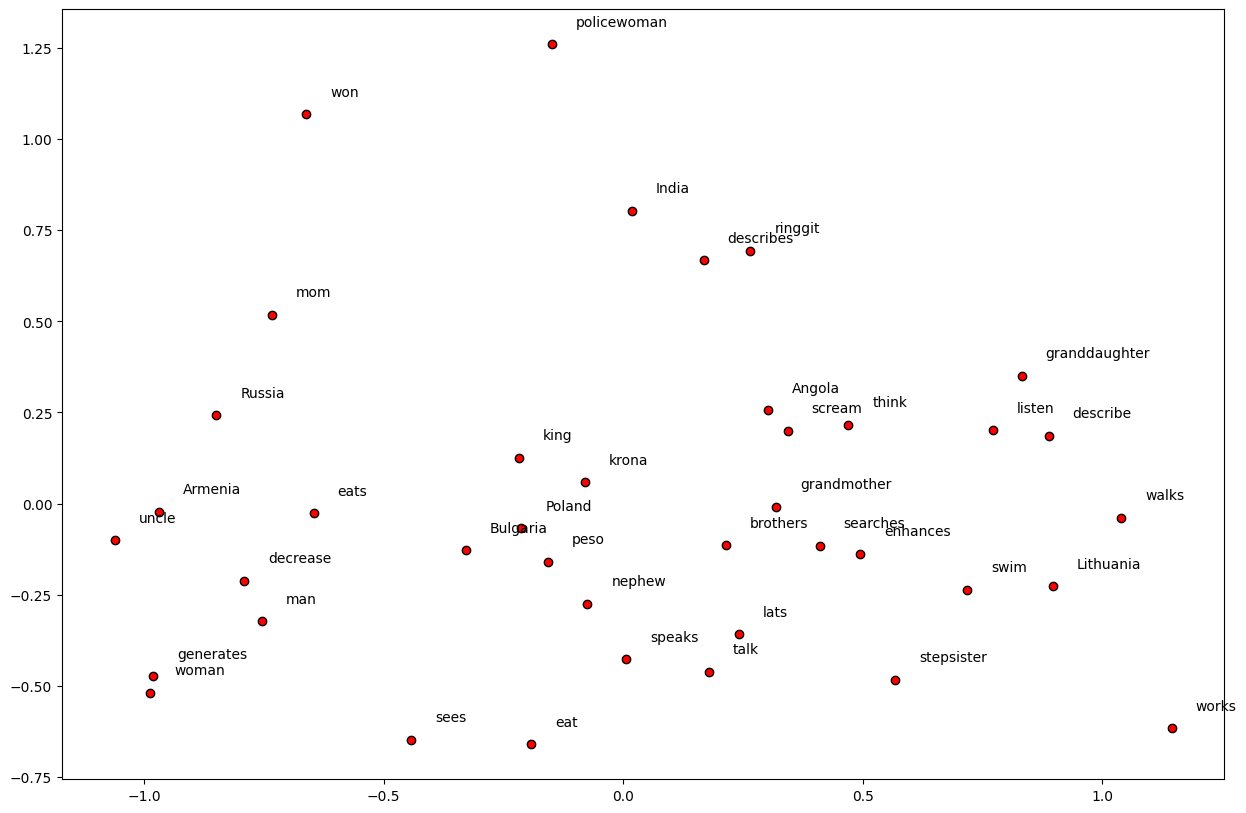

In [19]:
from sklearn.decomposition import PCA # referenced from my friend
import numpy as np
import matplotlib.pyplot as plt
for oo in words :
    vec_word.append(np.array(get_embed(oo, Skipgram)))
word_vectors = vec_word
twodim = PCA().fit_transform(word_vectors)[:,:2]  #transform 4 to 2 dimensions

plt.figure(figsize=(15,10))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, twodim):
    plt.text(x+0.05, y+0.05, word)
plt.show()

## 8. Revision on Analogy

In [20]:
vectors = { token:np.array(get_embed(token, Skipgram)) for token in vocabs }

vectors_sementic = { token:np.array(get_embed(token, Skipgram)) for token in vocabs_sem } # for test accuracy
vectors_syntactic = { token:np.array(get_embed(token, Skipgram)) for token in vocabs_syn }

In [21]:
dict(itertools.islice(vectors_sementic.items(), 10)) # show several examples

{'peso': array([ 0.02124178,  0.12962236, -0.25118351]),
 'Armenia': array([0.26601517, 0.97365499, 0.05260557]),
 'man': array([ 0.11460383,  0.86755943, -0.26764026]),
 'Angola': array([-0.29521307, -0.26211092,  0.11265632]),
 'India': array([ 0.05237138, -0.27366027,  0.64649063]),
 'Bulgaria': array([ 0.05562389,  0.32372895, -0.1809926 ]),
 'ringgit': array([ 0.21408796, -0.73468107,  0.42477086]),
 'Russia': array([ 1.1821444 , -0.04867852,  0.04010355]),
 'mom': array([0.81224483, 0.08792408, 0.37810025]),
 'Lithuania': array([-0.59395009, -0.71602535, -0.45812398])}

In [22]:
sum = (vectors["dad"]-vectors["mom"])+vectors["brothers"]

In [23]:
# revision
sum_value = np.dot(sum, vectors["brothers"]) / (np.linalg.norm(sum) * np.linalg.norm(vectors["brothers"]))
print(f" 'dad' - 'mom' + 'brothers' similarity to 'sister' at {sum_value*100} percentage")

 'dad' - 'mom' + 'brothers' similarity to 'sister'  at 77.32987726206333 percentage


In [25]:
def analogy(x1, x2, y1, vectors): 
    x1_vec, x2_vec, y1_vec = vectors[x1], vectors[x2], vectors[y1]
    result_vec = y1_vec + (x2_vec - x1_vec)
    result = closest_word(result_vec, vectors)
    return result

# function to find closest word to a given vector
def closest_word(vec, vectors):
    closest_idx = np.argmax([cosine_similarity(vec, v) for v in vectors.values()]) # argmax used in order to find the index of closest word - in other words, this line is used to find the most similarity from the result vector to vector of all vocabs
    return list(vectors.keys())[closest_idx]

# calculating cosine similarity
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [26]:
def test_senario(a1 , a2, model_l) :
    tester1 = get_embed(a1, model_l)
    teater2 = get_embed(a2, model_l)
    print(f"{a1} similarity to {a2} = {cosine_similarity(tester1 , teater2)}")

In [29]:
test_senario("table","chair" , Skipgram)

table similarity to chair = 1.0


In [30]:
test_senario("eat","drink", Skipgram)


eat similarity to drink = 0.3644364161339244


In [32]:
analogy('king', 'queen', 'prince', vectors) # --?

'eat'

In [33]:
def extract_word(word_m) :
    word_cc = []
    for value in word_m :
        temporary = []
        for indx in range (len(value)) :
            temporary.append(value[indx])
            if int(indx + 1) % int(2) == 0 :
                if temporary not in word_cc :
                    word_cc.append(temporary)
                temporary = []
    return word_cc                   

In [34]:
semantic_word = extract_word(cor_sem_token) # [['boy', 'girl'], .....] in this format after extraction
syntactic_word = extract_word(cor_syn_token)

In [36]:
len(syntactic_word), len(semantic_word)

(30, 53)

In [37]:
def acc_test (word_test , vector_target) :
    count = 0
    round = 0
    print(f"the correct word is : ")
    for tokens in word_test : # word_cc[0] look like this [decrease , decreases] then i loop and check analogy every word
        word1 = tokens[0]
        word2 = tokens[1]
        for ss in range (len(word_test)) :
            if str(word1) != str(word_test[ss][0]) :
                relt  = analogy( str(word1), str(word2), word_test[ss][0], vector_target)
                round = round+1
                if str(relt) == str(word_test[ss][1]) :
                    print(f'{word1} is to {word2} as {word_test[ss][0]} to {relt}')
                    count = count + 1     
            else : 
                pass        
    accuracy = (abs(count/round)) * 100        
    print(f"test {round} time correct {count} time, you accuracy is {accuracy :.2f} percentage")    
    return accuracy

In [38]:
# this dataset have 30 pair of singular and phural verbs. When loop to check with every word should be 900 round but there are 30 pair that repeated. --> revision
skipgram_syn_acc = acc_test(syntactic_word, vectors_syntactic)

the correct word is : 
decrease is to decreases as scream to screams
enhance is to enhances as write to writes
find is to finds as generate to generates
generate is to generates as find to finds
go is to goes as scream to screams
increase is to increases as think to thinks
increase is to increases as vanish to vanishes
sit is to sits as estimate to estimates
sit is to sits as provide to provides
slow is to slows as describe to describes
talk is to talks as increase to increases
talk is to talks as think to thinks
think is to thinks as eat to eats
write is to writes as enhance to enhances
write is to writes as walk to walks
test 870 time correct 15 time, you accuracy is 1.72 percentage


In [39]:
skipgram_sem_acc = acc_test(semantic_word, vectors_sementic)

the correct word is : 
Angola is to kwanza as Lithuania to litas
Argentina is to peso as Brazil to real
Bulgaria is to lev as dad to mom
Bulgaria is to lev as grandson to granddaughter
Cambodia is to riel as groom to bride
Denmark is to krone as Bulgaria to lev
Denmark is to krone as dad to mom
Europe is to euro as Romania to leu
Hungary is to forint as brother to sister
India is to rupee as his to her
India is to rupee as husband to wife
Japan is to yen as husband to wife
Latvia is to lats as sons to daughters
Macedonia is to denar as Hungary to forint
Malaysia is to ringgit as Brazil to real
Malaysia is to ringgit as Vietnam to dong
Mexico is to peso as his to her
Mexico is to peso as husband to wife
Nigeria is to naira as grandfather to grandmother
Nigeria is to naira as husband to wife
Sweden is to krona as Lithuania to litas
Thailand is to baht as Romania to leu
Thailand is to baht as USA to dollar
boy is to girl as Sweden to krona
brother is to sister as Hungary to forint
dad is 

# CBOW

## 1. Prepare the data

In [40]:
# it is already tokenizing and numerizing the data

def random_batch_CBOW(batch_size, corpus_tokenized):
    
    CBOW = []

    #for each corpus
    for sent in corpus_tokenized:
        try :
            for i in range(1, len(sent) - 1): #start from 1 to second last
                center_word = word_2_idx[sent[i]]
                outside_words = [word_2_idx[sent[i-1]], word_2_idx[sent[i+1]]]  #window_size = 1
                for o in outside_words:
                    CBOW.append([o,center_word ]) #use outside word to predict center word
        except :
            pass               
    #only get a batch, not the entire list
    random_inputs, random_labels = [], []   
    random_index = np.random.choice(range(len(CBOW)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    for index in random_index:
        random_inputs.append([CBOW[index][0]])  
        random_labels.append([CBOW[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

## 2. Model 

In [41]:
class CBOW(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(CBOW, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        top_term_exp = torch.exp(top_term) 
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) 
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))

        
        return loss_fn

## 3.Train

In [42]:
CBOW = CBOW(voc_size, emb_size)
optimizer  = optim.Adam(CBOW.parameters(), lr=0.001)
run_time_normal = 0
sum_time = 0
#for epoch
for epoch in range(num_epochs):
    start_time = time.time()
    #get random batch
    input_batch, label_batch = random_batch_CBOW(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    #loss = model
    optimizer.zero_grad()
    loss = CBOW(input_batch, label_batch, all_vocabs)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()
    stop_time = time.time()
    run_time_normal = run_time_normal + epoch_time(start_time, stop_time)
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        sum_time += run_time_normal
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {run_time_normal} s")
        run_time_normal = 0
print(f"Time in total: {sum_time} " )

Epoch 1000 | Loss: 7.459122 | Time: 12.305271863937378 s
Epoch 2000 | Loss: 4.626183 | Time: 9.033655881881714 s
Epoch 3000 | Loss: 5.365932 | Time: 9.093980550765991 s
Epoch 4000 | Loss: 5.757639 | Time: 9.113869905471802 s
Time in total: 39.546778202056885 


In [43]:
vectors_CBOW = { token:np.array(get_embed(token, CBOW)) for token in vocabs }

CBOW_sementic = { token:np.array(get_embed(token, CBOW)) for token in vocabs_sem }
CBOW_syntactic = { token:np.array(get_embed(token, CBOW)) for token in vocabs_syn }

In [44]:
CBOW_sem_acc = acc_test(semantic_word, CBOW_sementic)

the correct word is : 
Angola is to kwanza as Bulgaria to lev
Angola is to kwanza as Croatia to kuna
Argentina is to peso as Croatia to kuna
Bulgaria is to lev as Croatia to kuna
Cambodia is to riel as Lithuania to litas
Canada is to dollar as Croatia to kuna
Europe is to euro as sons to daughters
Hungary is to forint as Argentina to peso
India is to rupee as Russia to ruble
Iran is to rial as Algeria to dinar
Lithuania is to litas as Poland to zloty
Nigeria is to naira as Cambodia to riel
Nigeria is to naira as Russia to ruble
Poland is to zloty as Denmark to krone
Romania is to leu as Lithuania to litas
Romania is to leu as he to she
Thailand is to baht as stepbrother to stepsister
boy is to girl as Croatia to kuna
boy is to girl as Europe to euro
brother is to sister as Algeria to dinar
brother is to sister as Europe to euro
brothers is to sisters as Croatia to kuna
dad is to mom as Europe to euro
grandfather is to grandmother as stepbrother to stepsister
grandpa is to grandma as Cr

In [45]:
CBOW_syn_acc = acc_test(syntactic_word, CBOW_syntactic)

the correct word is : 
decrease is to decreases as describe to describes
eat is to eats as estimate to estimates
eat is to eats as play to plays
enhance is to enhances as describe to describes
enhance is to enhances as sing to sings
find is to finds as estimate to estimates
find is to finds as play to plays
go is to goes as scream to screams
increase is to increases as say to says
scream is to screams as swim to swims
search is to searches as predict to predicts
search is to searches as sit to sits
see is to sees as decrease to decreases
see is to sees as describe to describes
shuffle is to shuffles as swim to swims
sing is to sings as go to goes
sit is to sits as describe to describes
swim is to swims as estimate to estimates
think is to thinks as work to works
vanish is to vanishes as predict to predicts
test 870 time correct 20 time, you accuracy is 2.30 percentage


# Negative sampling

## 1. Prepare the data

In [47]:
Z = 0.001
unigram_table = []

In [48]:
from collections import Counter # referenced from my friend
import random

word_count = Counter(flatten(corpus_tokenized))
aa = [c for w, c in word_count.items()]
sumsum = 0
for i in range(len(aa)) :
    sumsum = sumsum + int(aa[i-1])
for vo in vocabs:
    unigram_table.extend([vo] * int(((word_count[vo]/sumsum)**0.75)/Z))    

In [49]:
def prepare_sequence_skip(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)
def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word_2_idx[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence_skip(nsample, word_2_idx).view(1, -1))
    
    return torch.cat(neg_samples)

## 2. Model

In [51]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_center_word(center_words) 
        target_embeds = self.embedding_outside_word(target_words) 
        neg_embeds    = -self.embedding_outside_word(negative_words) 
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1) # here is the loss function
                
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_center_word(inputs)
        
        return embeds

## 3. Let's train the data

In [52]:
Skip_Neg = SkipgramNegSampling(voc_size, emb_size)
optimizer_Neg  = optim.Adam(Skip_Neg.parameters(), lr=0.001)

In [53]:
run_time_negative = 0
sum_time_negative = 0
num_neg        = 15

for epoch in range(num_epochs):
    
    start = time.time()
    input_batch, target_batch = random_batch_skipgram(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    optimizer_Neg.zero_grad()
    loss = Skip_Neg(input_batch, target_batch, negs_batch)

    loss.backward()
    optimizer_Neg.step()
    end = time.time()
    run_time_negative = run_time_negative + epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        sum_time_negative += run_time_negative
        print(f"Epoch: {epoch + 1} | loss: {loss:.6f} | time: {run_time_negative} s")
        run_time_negative = 0
print(f"Total time with {num_epochs} epoch is: {sum_time_negative} s")     

Epoch: 1000 | loss: 15.193077 | time: 9.41211986541748 s
Epoch: 2000 | loss: 13.409737 | time: 9.981069803237915 s
Epoch: 3000 | loss: 13.875822 | time: 9.403099536895752 s
Epoch: 4000 | loss: 10.530771 | time: 8.942537546157837 s
Total time with 4000 epoch is: 37.738826751708984 s


In [54]:
vectors_Neg = { token:np.array(get_embed(token, Skip_Neg)) for token in vocabs } # same as previous
Neg_sementic = { token:np.array(get_embed(token, Skip_Neg)) for token in vocabs_sem }
Neg_syntactic = { token:np.array(get_embed(token, Skip_Neg)) for token in vocabs_syn }

In [55]:
Neg_syn_acc = acc_test(syntactic_word, Neg_syntactic)

the correct word is : 
eat is to eats as sing to sings
find is to finds as provide to provides
predict is to predicts as see to sees
provide is to provides as find to finds
provide is to provides as go to goes
sing is to sings as eat to eats
sit is to sits as see to sees
write is to writes as enhance to enhances
test 870 time correct 8 time, you accuracy is 0.92 percentage


In [56]:
Neg_sem_acc = acc_test(semantic_word, Neg_sementic)

the correct word is : 
Angola is to kwanza as Europe to euro
Argentina is to peso as brother to sister
Argentina is to peso as stepson to stepdaughter
Armenia is to dram as Russia to ruble
Brazil is to real as stepson to stepdaughter
Cambodia is to riel as Bulgaria to lev
Canada is to dollar as Romania to leu
Croatia is to kuna as his to her
Denmark is to krone as Romania to leu
India is to rupee as boy to girl
India is to rupee as husband to wife
Korea is to won as Nigeria to naira
Korea is to won as stepbrother to stepsister
Latvia is to lats as Nigeria to naira
Latvia is to lats as stepbrother to stepsister
Lithuania is to litas as Ukraine to hryvnia
Malaysia is to ringgit as Bulgaria to lev
Mexico is to peso as Bulgaria to lev
Poland is to zloty as Vietnam to dong
Poland is to zloty as dad to mom
Poland is to zloty as stepfather to stepmother
Romania is to leu as Denmark to krone
Ukraine is to hryvnia as Lithuania to litas
boy is to girl as brother to sister
dad is to mom as stepbr

# GloVe Revision

##  1. Co-occurrence matrix, which count the occurrences of pair of words using window size of 1

In [57]:
skip_grams = []

#loop through each corpus
for sent in corpus_tokenized:  #['apple', 'banana', 'fruit']
    #loop through each word from 1 to n-1 (because 0 and n has no context window)
    for i in range(1, len(sent)-1):
        target  = sent[i]
        context = [sent[i+1], sent[i-1]]
        #append(i, i+1) and append(i, i-1)
        for c in context:
            skip_grams.append((target, c))

In [58]:
X_ik_skipgram = Counter(skip_grams)

In [59]:
dict(itertools.islice(X_ik_skipgram.items(), 10)) # show several examples in dictionary

{('dinar', 'Angola'): 1,
 ('dinar', 'Algeria'): 29,
 ('Angola', 'kwanza'): 29,
 ('Angola', 'dinar'): 1,
 ('dinar', 'Argentina'): 1,
 ('Argentina', 'peso'): 28,
 ('Argentina', 'dinar'): 1,
 ('dinar', 'Armenia'): 1,
 ('Armenia', 'dram'): 29,
 ('Armenia', 'dinar'): 1}

## 2. Weighting function 

GloVe includes a weighting function to scale down too frequent words.


In [60]:
def weighting(w_i, w_j, X_ik):
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [61]:
#now apply this weighting to all possible pairs
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)
    

## 3. Prepare data

In [62]:
import math

def random_batch_glolve(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #loop through this skipgram, and change it id  because when sending model, it must number
    skip_grams_id = [(word_2_idx[skip_gram[0]], word_2_idx[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly pick "batch_size" indexes
    number_of_choices = len(skip_grams_id)
    random_index = np.random.choice(number_of_choices, batch_size, replace=False) #no repeating indexes among these random indexes
    
    random_inputs = [] #xi, wi (in batches)
    random_labels = [] #xj, wj (in batches)
    random_coocs  = [] #Xij (in batches)
    random_weighting = [] #f(Xij) (in batches)
    #for each of the sample in these indexes
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]]) #same reason why i put bracket here....
        random_labels.append([skip_grams_id[i][1]])
        
        #get cooc
        #first check whether it exists...
        pair = skip_grams[i]  #e.g., ('banana', 'fruit)
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1 #label smoothing
            
        random_coocs.append([math.log(cooc)])  #1. why log, #2, why bracket -> size ==> (, 1)  #my neural network expects (, 1)
        
        #get weighting
        weighting = weighting_dic[pair]  #why not use try....maybe it does not exist....
        random_weighting.append(weighting)

        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weighting)
    

## 4. Model

In [63]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_center_word = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_outside_word = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_center_word(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_outside_word(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

## 5. Training

In [64]:
#for epoch
Glove_model = GloVe(voc_size, emb_size)
optimizer_Neg  = optim.Adam(Glove_model.parameters(), lr=0.001)
run_time_normal = 0
sum_time = 0
for epoch in range(num_epochs):

    #get random batch
    input, target, cooc, weightin = random_batch_glolve(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)
    input_batch    = torch.LongTensor(input)
    target_batch   = torch.LongTensor(target)
    cooc_batch     = torch.FloatTensor(cooc)
    weightin_batch = torch.FloatTensor(weightin)
    
    
    #loss = model
    optimizer.zero_grad()
    loss = Glove_model(input_batch, target_batch, cooc_batch, weightin_batch)
    loss.backward()

    #update alpha
    optimizer.step()
    stop_time = time.time()
    run_time_normal = run_time_normal + epoch_time(start_time, stop_time)
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        sum_time += run_time_normal
        print(f"Epoch: {epoch + 1} | loss: {loss:.6f} | time: {run_time_normal} s")
        run_time_normal = 0
print(f"Total time of {num_epochs} epoch is: {sum_time} s")   

Epoch: 1000 | loss: 5.262538 | time: 427074.9529144764 s
Epoch: 2000 | loss: 20.205996 | time: 429608.3503961563 s
Epoch: 3000 | loss: 12.225985 | time: 432071.3382406235 s
Epoch: 4000 | loss: 1.330602 | time: 434971.95698809624 s
Total time of 4000 epoch is: 1723726.5985393524 s


In [65]:
vectors_GloVe = { token:np.array(get_embed(token, Glove_model)) for token in vocabs }

GloVe_sementic = { token:np.array(get_embed(token, Glove_model)) for token in vocabs_sem }
GloVe_syntactic = { token:np.array(get_embed(token, Glove_model)) for token in vocabs_syn }

In [66]:
GloVe_syn_acc = acc_test(syntactic_word, GloVe_syntactic)

the correct word is : 
find is to finds as provide to provides
search is to searches as estimate to estimates
sing is to sings as enhance to enhances
think is to thinks as provide to provides
vanish is to vanishes as sing to sings
walk is to walks as shuffle to shuffles
test 870 time correct 6 time, you accuracy is 0.69 percentage


In [67]:
GloVe_sem_acc = acc_test(semantic_word, GloVe_sementic)

the correct word is : 
Armenia is to dram as Denmark to krone
Armenia is to dram as husband to wife
Cambodia is to riel as grandpa to grandma
Canada is to dollar as uncle to aunt
Denmark is to krone as Armenia to dram
Europe is to euro as prince to princess
Japan is to yen as Ukraine to hryvnia
Lithuania is to litas as Russia to ruble
Lithuania is to litas as brothers to sisters
Poland is to zloty as Vietnam to dong
Romania is to leu as Brazil to real
Russia is to ruble as Lithuania to litas
Russia is to ruble as brothers to sisters
USA is to dollar as policeman to policewoman
brother is to sister as Hungary to forint
brother is to sister as grandpa to grandma
his is to her as stepbrother to stepsister
king is to queen as boy to girl
prince is to princess as Europe to euro
sons is to daughters as stepson to stepdaughter
test 2756 time correct 20 time, you accuracy is 0.73 percentage


# Corelation
### This part is totally learned from my friend for comparison step

In [68]:
# Write the equation with numpy
def spearman(x, y):
    # convert input lists to numpy arrays
    x = np.array(x)
    y = np.array(y)
    # calculate rank of x and y
    x_rank = np.argsort(np.argsort(x)) + 1
    y_rank = np.argsort(np.argsort(y)) + 1
    # calculate difference between rank of x and y
    diff = x_rank - y_rank
    # calculate the square of the difference
    diff_sq = diff**2
    # calculate the sum of the square of the difference
    diff_sum = diff_sq.sum()
    # calculate the Spearman rank correlation coefficient
    n = len(x)
    spearman = 1 - ((6*diff_sum) / (n*(n**2 - 1)))
    return spearman

In [69]:
data = pd.read_csv("testing.txt", sep='\t', names=["word1", "word2", "human_score"])
models = [CBOW,Skipgram,Skip_Neg,Glove_model]
corre = []

for i in range(4):
    sim_array = []
    humar_array = []
    
    # data is the dataframe containing the word pairs and human-assigned similarity scores - borrowed from my friend
    for index,row in data.iterrows():
        word1 = row["word1"]
        word2 = row["word2"]
        human_score = row["human_score"]
        if word1 in vocabs and word2 in vocabs:

            center_embeds = get_embed(word1,models[i]) # [batch_size, 1, emb_size]
            target_embeds = get_embed(word2,models[i]) # [batch_size, 1, emb_size]

            # Calculate cosin_similarity
            similarity = cosine_similarity(center_embeds,target_embeds)
            sim_array.append(similarity)
            humar_array.append(human_score)


    # Calculate corelation with spearman Equation
    correlation = spearman(humar_array, sim_array)
    corre.append(correlation)

In [70]:
from tabulate import tabulate
model_name = ["CBOW","Skipgram","Skipgram_Negative","GloVe"]
# creating a DataFrame
dict = {'Name':model_name,
        'Semantic Accuracy':[CBOW_sem_acc,skipgram_sem_acc,Neg_sem_acc,GloVe_sem_acc],
        'Syntactic Accuracy':[CBOW_syn_acc,skipgram_syn_acc,Neg_syn_acc,GloVe_syn_acc],
        'Correlation':corre}

df = pd.DataFrame(dict)

# displaying the DataFrame
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

+----+-------------------+---------------------+----------------------+---------------+
|    | Name              |   Semantic Accuracy |   Syntactic Accuracy |   Correlation |
|----+-------------------+---------------------+----------------------+---------------|
|  0 | CBOW              |            1.34253  |             2.29885  |           1   |
|  1 | Skipgram          |            1.26996  |             1.72414  |           0   |
|  2 | Skipgram_Negative |            1.37881  |             0.91954  |           0.4 |
|  3 | GloVe             |            0.725689 |             0.689655 |          -0.8 |
+----+-------------------+---------------------+----------------------+---------------+
